In [1]:
from ml4floods.data import cmkappazeta
import rasterio
import rasterio.plot as rasterioplt
import numpy as np


import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/home/gonzalo/Downloads/ML4CC General-GOOD.json'


2021-08-05 15:43:28.641062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-05 15:43:28.641086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model = cmkappazeta.Unet()
model.construct()
model.model.summary()

2021-08-05 15:43:30.967758: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-05 15:43:31.018484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-05 15:43:31.018879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-08-05 15:43:31.019029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-05 15:43:31.019176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcu

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 6976        input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [3]:
model.load_weights(filelocal="./l1c__091-0.42.hdf5")
# model.load_weights("../weights/l1c__091-0.42.hdf5")

In [4]:
%%time

path = "gs://ml4cc_data_lake/2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR333_02PORTOPALO_DEL_MONIT01_v1_observed_event_a.tif"
# path = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR517/AOI15/S2/2021-07-18.tif"

channels = [c+1 for c in [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]]
with rasterio.open(path) as src:
    data = src.read(channels)
    data = np.nan_to_num(data,nan=0)
    crs = src.crs
    transform = src.transform

print(data.shape)

(12, 1391, 1766)
CPU times: user 1.5 s, sys: 326 ms, total: 1.83 s
Wall time: 11.4 s


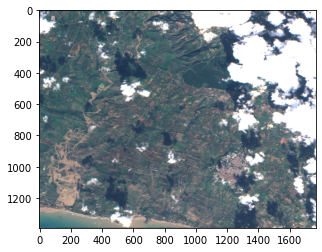

<AxesSubplot:>

In [5]:
rgb = np.clip(data[(3,2,1),...]/3000., 0, 1)
rasterioplt.show(rgb)

In [6]:
# window_x, window_y = slice(512,1024), slice(512,1024)
# data_to_pred = data[:, window_y, window_x]

pred = model.predict(data)
# data_to_pred = data[bands_indexes, window_y, window_x] / norm_factor / max_v[:, None, None]

pred.shape

2021-08-05 15:43:44.504219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-05 15:43:44.522761: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz
2021-08-05 15:43:44.748050: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 440664064 exceeds 10% of free system memory.
2021-08-05 15:43:44.912717: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 440664064 exceeds 10% of free system memory.
2021-08-05 15:43:45.413892: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 110166016 exceeds 10% of free system memory.
2021-08-05 15:43:45.519590: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 220332032 exceeds 10% of free system memory.
2021-08-05 15:43:45.753814: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 220332032 exceeds 10% of free system memory.


(1391, 1766)

<AxesSubplot:>

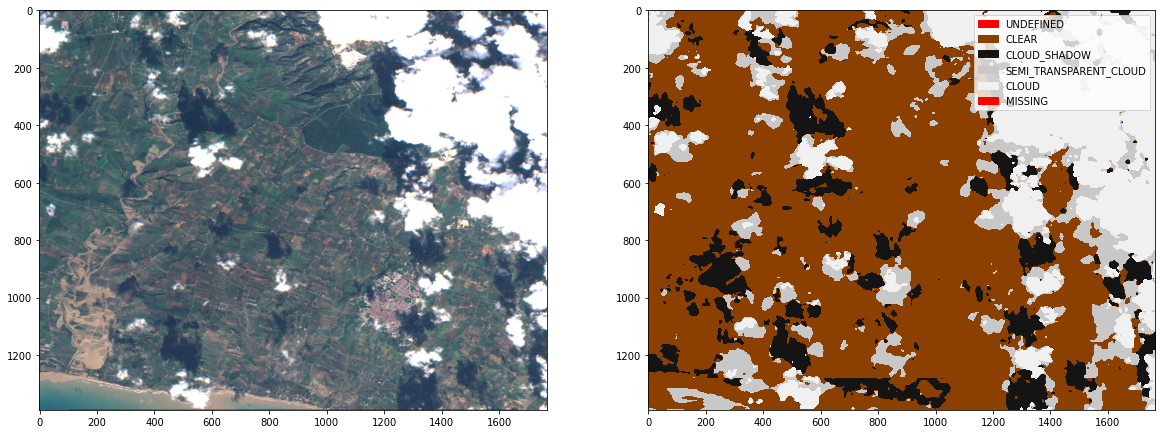

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

cmkappazeta.plot_pred(pred, ax=ax[1])

rasterioplt.show(rgb,ax=ax[0])

In [9]:
np.unique(pred,return_counts=True)

(array([1, 2, 3, 4, 5], dtype=uint8),
 array([1395271,  273810,  306535,  480878,      12]))

In [8]:
df_vector = cmkappazeta.vectorize_output(pred, crs, transform)

/home/gonzalo/miniconda3/envs/ml4floods/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

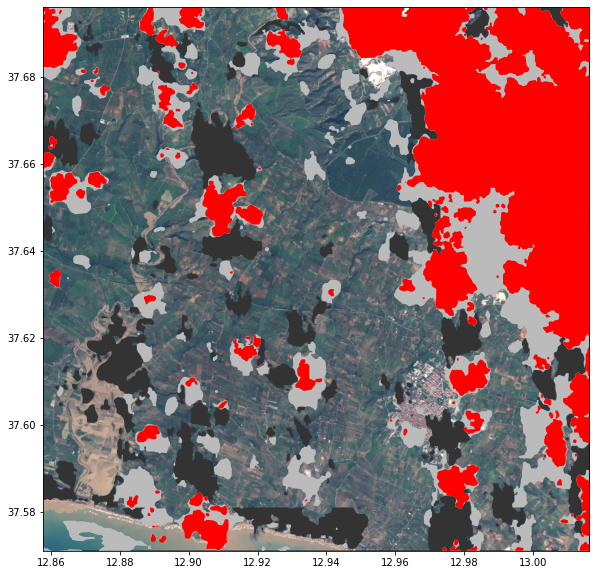

In [28]:
color_dict = {"CLOUD_SHADOW": '#333333', "THICK AND THIN CLOUDS": "#BBBBBB", "CLOUD": "r"}
colors = df_vector["class"].apply(lambda x: color_dict[x])

fig, ax = plt.subplots(1,1, figsize=(10,10))

rasterioplt.show(rgb,ax=ax, transform=transform)
df_vector.plot("class", ax=ax,color=colors)